In [1]:
### Opening nxs

import h5py
import numpy as np
import napari

def find_datasets_with_dim_3(file, group=None, path="", results=None):
    """
    Find all datasets with 3 dimensions in a HDF5 file.       
    """
    if results is None:
        results = []

    if group is None:
        group = file

    for key in group:
        item = group[key]
        current_path = f"{path}/{key}"
        if isinstance(item, h5py.Group):
            find_datasets_with_dim_3(
                file, group=item, path=current_path, results=results
            )
        elif isinstance(item, h5py.Dataset):
            if len(item.shape) == 3:
                results.append(
                    (current_path, item.shape)
                ) 
    return results

projs_path = r"D:\SOLEIL0125\025_mdb13_nocell_nocell_2d\025_mdb13_nocell_nocell_2d\025_mdb13_nocell_nocell_2d.nxs"
dark_path = r"D:\SOLEIL0125\025_mdb13_nocell_nocell_2d\025_mdb13_nocell_nocell_2d\post_dark.nxs"
flat_paths = r"D:\SOLEIL0125\025_mdb13_nocell_nocell_2d\025_mdb13_nocell_nocell_2d\post_ref.nxs"

with h5py.File(projs_path, 'r') as file:
    projs_key = find_datasets_with_dim_3(file)[0][0]
    projs = np.array(file[projs_key])
print("Projections shape:", projs.shape)

with h5py.File(dark_path, 'r') as file:
    dark_key = find_datasets_with_dim_3(file)[0][0]
    dark = np.mean(np.array(file[dark_key]), axis=0)
print("Dark shape:", dark.shape)

flat = []
with h5py.File(flat_paths, 'r') as file:
    flat_key = find_datasets_with_dim_3(file)[0][0]
    flat = np.mean(np.array(file[flat_key]), axis=0)
print("Flat shape:", flat.shape)

Projections shape: (2850, 1200, 1472)
Dark shape: (1200, 1472)
Flat shape: (1200, 1472)


In [1]:
import h5py
import numpy as np

### Opening data ###

filename = r"d:\Elettra_24\eth70\B1\rawdata\B1-Eth70_Z4.5mm.tdf"
hf = h5py.File(filename,'r')
dset = hf['exchange']
white = np.median(dset['data_white'], axis=1)
print('White shape: ', white.shape)

dark = np.median(dset['data_dark'], axis=1)
print('Dark shape: ', dark.shape)
proj = dset['data']
projs=np.swapaxes(np.asarray(proj), 0, 1)
print('Data shape: ', projs.shape)

White shape:  (1548, 2045)
Dark shape:  (1548, 2045)
Data shape:  (3600, 1548, 2045)


In [ ]:
import numpy as np

projs = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_projs.npy")
projs = np.swapaxes(projs, 0, 1)
print("Projections shape:", projs.shape)
dark = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_darks.npy")
dark = np.median(dark, axis=1)
print("Dark shape:", dark.shape)
flat = np.load(r"C:\Users\clement.capdeville\Documents\GitHub\Phase_contrast\data\B1_50_z0_whites.npy")
flat = np.median(flat, axis=1)
print("Flat shape:", flat.shape)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(projs, name='Projections')
viewer.add_image(dark, name='Dark')
viewer.add_image(flat, name='Flat')

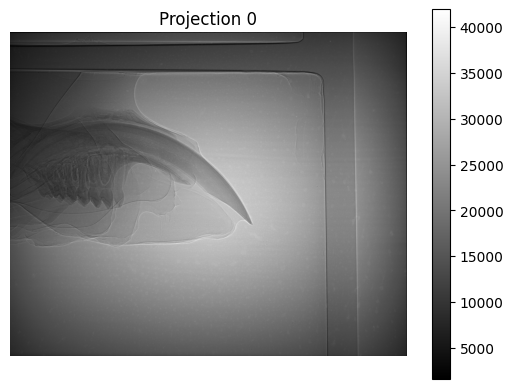

In [2]:
def display_slice(slice, title='Slice', cmap='gray', vmin=None, vmax=None, colorbar=False):
    """
    Display a slice with matplotlib dans un 1:1 aspect ratio

    Parameters
    ----------
    slice : numpy array
        Slice to display
    title : str
        Title of the plot
    cmap : str
        Color map to use

    Returns
    -------
    None
    
    """
    import matplotlib.pyplot as plt

    plt.imshow(slice, cmap=cmap, vmin=vmin, vmax=vmax)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')

    if colorbar:
        plt.colorbar()
        
    plt.title(title)

    plt.show()

display_slice(projs[0], title='Projection 0', cmap='gray', colorbar=True)

In [3]:
### Get Center of Rotation from csv file


import pandas as pd
import os

csv_path = r"C:\Users\clement.capdeville\Documents\GitHub\SOLEIL25\part_info.csv"
part_info = pd.read_csv(csv_path)
filtered_info = part_info.loc[part_info["Path"] == os.path.basename(projs_path).split(".")[0]]
CoR = filtered_info["CoR"].values[0] if not filtered_info.empty else None
angle_padding = filtered_info["Angle"].values[0] if not filtered_info.empty else None

print("CoR:", CoR)
print("Angle padding:", angle_padding)

CoR: 287.5329942270546
Angle padding: 0.1264044943820224


Preprocessing projections: 100%|██████████| 2850/2850 [00:08<00:00, 345.15it/s]


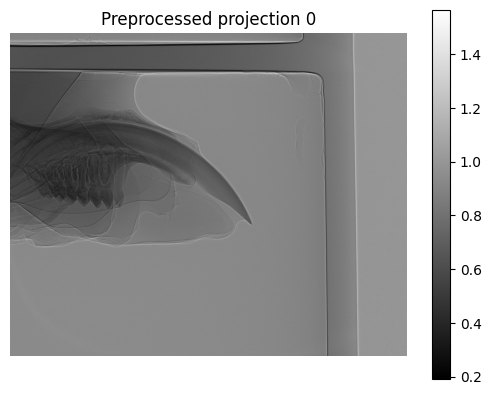

In [4]:
### Preprocessing

import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

def preprocess(proj, dark, flat):

    num = proj - dark
    den = flat - dark
    
    den[den == 0] = 1e-12
    
    return num / den

projs = np.array(Parallel(n_jobs=-1, backend='threading')(
    delayed(preprocess)(proj, dark, flat) 
    for proj in tqdm(projs, desc='Preprocessing projections')))

display_slice(projs[0], title='Preprocessed projection 0', cmap='gray', colorbar=True)

In [7]:
import math
from cupy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq
from cupyx.scipy.ndimage import gaussian_filter
from numpy import pi
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from skimage.draw import disk
import astra
import cupy as cp


def keVtoLambda(energy_kev):
    """
    Convert energy in keV to wavelength in m.

    Parameters
    ----------
    energy_kev : float
        Energy in keV

    Returns
    -------
    float
        Wavelength in m
    """
    h = 6.58211928e-19  # Planck constant in keV·s
    c = 299792458       # Speed of light in m/s
    return h * c / energy_kev

def phase_retrieval(I, delta_beta, dist_obj_detector, energy_kev, pixel_size):
    """
    Apply phase retrieval according to formula (6) from Weitkamp et al. (2011).

    Parameters
    ----------
    I : cupy.ndarray
        Measured intensity image.
    delta_beta : float
        Beta/delta ratio.
    dist_obj_detector : float
        Propagation distance (m).
    energy_kev : float
        X-ray energy (keV).
    pixel_size : float
        Detector pixel size (m).

    Returns
    -------
    phi : numpy.ndarray
        Reconstructed phase map.
    """
    wavelength = keVtoLambda(energy_kev)
    ny, nx = I.shape

    # Spatial frequencies
    u = fftfreq(nx, d=pixel_size)
    v = fftfreq(ny, d=pixel_size)
    U, V = cp.meshgrid(u, v, indexing='ij')

    # Fourier transform of the image
    I_fft = fftshift(fft2(I))

    # Compute filter
    denominator = 1 + cp.pi * wavelength * dist_obj_detector * delta_beta * (U**2 + V**2)
    denominator[denominator == 0] = cp.finfo(float).eps  # Avoid division by zero

    # Apply filter and inverse FFT
    phi_fft = I_fft / denominator
    phi = - cp.log(cp.maximum(cp.real(ifft2(ifftshift(phi_fft))), cp.finfo(cp.float32).eps)) * delta_beta * 0.5

    return phi

def get_padding_size(image, energy, effective_pixel_size, distance):
    """
    Calculate the padding size for a 2D image.

    Parameters
    ----------
    image : cupy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    tuple
        Padded sizes (nx_padded, ny_padded)
    """
    ny, nx = image.shape
    wavelength = keVtoLambda(energy)

    n_margin = math.ceil(3 * wavelength * distance / (2 * effective_pixel_size ** 2))
    nx_margin = nx + 2 * n_margin
    ny_margin = ny + 2 * n_margin

    nx_padded = int(2 ** math.ceil(math.log2(nx_margin)))
    ny_padded = int(2 ** math.ceil(math.log2(ny_margin)))

    return nx_padded, ny_padded

def padding(image, energy, effective_pixel_size, distance):
    """
    Pad a 2D image to avoid edge artifacts during phase retrieval with the closest value.

    Parameters
    ----------
    image : cupy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    tuple
        Padded image, padded nx, padded ny
    """
    ny, nx = image.shape
    nx_padded, ny_padded = get_padding_size(image, energy, effective_pixel_size, distance)

    top = (ny_padded - ny) // 2
    bottom = ny_padded - ny - top
    left = (nx_padded - nx) // 2
    right = nx_padded - nx - left

    padded_image = cp.pad(image, ((top, bottom), (left, right)), mode='reflect')
    return padded_image, nx_padded, ny_padded

def unsharp_mask(image: cp.ndarray, sigma: float = 1.0, coeff: float = 1.0) -> cp.ndarray:
    blurred = gaussian_filter(image, sigma=sigma, mode='reflect')
    return (1 + coeff) * image - coeff * blurred

def process_projection(proj, nx, ny, energy, effective_pixel_size, distance, delta_beta, pixel_size, sigma, coeff):
    """
    Process a single projection image.

    Parameters
    ----------
    proj : cupy.ndarray
        Projection image.
    nx : int
        Original width of the image.
    ny : int
        Original height of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).
    delta_beta : float
        Ratio beta/delta for phase retrieval.
    pixel_size : float
        Detector pixel size (m).

    Returns
    -------
    numpy.ndarray
        Cropped phase-retrieved projection.
    """

    proj_cp = cp.asarray(proj)
    padded_proj, nx_padded, ny_padded = padding(proj_cp, energy, effective_pixel_size, distance)
    retrieved_proj = phase_retrieval(padded_proj, delta_beta, distance, energy, pixel_size)
    retrieved_proj = unsharp_mask(retrieved_proj, sigma=sigma, coeff=coeff)

    x_margin = (nx_padded - nx) // 2
    y_margin = (ny_padded - ny) // 2

    return retrieved_proj[y_margin:y_margin + ny, x_margin:x_margin + nx].get()

retrieved_projs = np.zeros_like(projs, dtype=np.float32)
i = 0

nx = projs.shape[2]
ny = projs.shape[1]
energy = 40
effective_pixel_size = 12e-6
distance = 1.2
delta_beta = 100
pixel_size = 12e-6
sigma = 2.0
coeff = 0.5

for proj in tqdm(projs, desc='Phase retrieval'):
    retrieved_projs[i] = process_projection(proj, nx, ny, energy, effective_pixel_size, distance, delta_beta, pixel_size, sigma, coeff)
    i += 1


Phase retrieval: 100%|██████████| 2850/2850 [01:29<00:00, 31.76it/s]


In [8]:
import napari
viewer = napari.Viewer()
napari.view_image(retrieved_projs)

napari.manifest -> 'multipaganinproject' could not be imported: The name field in the manifest ('multipaganin-plugin') must match the package name ('multipaganinproject')


Viewer(camera=Camera(center=(0.0, 599.5, 735.5), zoom=0.3872282608695652, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1424.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=2849.0, step=1.0), RangeTuple(start=0.0, stop=1199.0, step=1.0), RangeTuple(start=0.0, stop=1471.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(1424.0, 599.0, 735.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'retrieved_projs' at 0x2782d1d83e0>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll 

In [5]:
### Double Flatfield Correction

def double_flatfield_correction(projs):
    """
    Apply double flat-field correction to an image.

    Parameters
    ----------
    proj : 2D numpy array
        Image to correct

    Returns
    -------
    I_corr : 2D numpy array
        Corrected image

    """

    mean_proj = np.mean(projs, axis=0)

    mean_proj[mean_proj == 0] = 1e-6

    I_corr = projs / mean_proj

    return I_corr


double_flatfield_projs = double_flatfield_correction(retrieved_projs)


In [ ]:
print("Double flatfield correction shape:", double_flatfield_projs.shape)

In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(double_flatfield_projs, name='Projections')
# viewer.add_image(normed_projs, name='Normed Projections')

In [ ]:
from joblib import Parallel, delayed
import cupy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def calc_cor_gpu(projs):
    """
    projs_cp: projections [angles, hauteur, largeur] (CuPy array)
    """
    theta, ny, nx = projs.shape
    start = 0
    stop = ny
    step = 10
    cor = cp.zeros((stop - start + step - 1) // step, dtype=cp.float16)  # Stocke les centres pour chaque ligne
    plot_data = []

    i = 0
    for y in tqdm(range(start, stop, step), desc="Recherche du COR par ligne"):
        # sinogramme d'une ligne horizontale
        sino1 = cp.asarray(projs[:theta // 2, y, ::-1])  # Première moitié inversée
        sino2 = cp.asarray(projs[theta // 2:, y, :])     # Deuxième moitié

        errors = cp.zeros(nx - 1, dtype=cp.float16)  # Stocke les erreurs pour chaque décalage
        for shift in range(1, nx):
            t1 = sino1[:, -shift:]
            t2 = sino2[:, :shift]
            if t1.shape != t2.shape:
                continue
            mse = cp.mean((t1 - t2) ** 2)
            errors[shift - 1] = mse

        best_shift = cp.argmin(errors)
        plot_data.append(errors.get())  # Convertit en NumPy pour le traçage
        cor[i] = (best_shift) / 2  # Position estimée du COR
        i += 1

    return cor.get(), plot_data  # Convertit `cor` en NumPy pour l'utilisation ultérieure

cor, plot = calc_cor_gpu(double_flatfield_projs)
# Affichage des résultats
plt.plot(plot[len(plot) // 2])  # Trace les erreurs pour la ligne centrale
plt.title("Erreur MSE selon le décalage (ligne centrale)")
plt.xlabel("Décalage")
plt.ylabel("Erreur")
plt.grid(True)
plt.show()

print(f"Centre estimé (ligne centrale) : {cor[len(cor) // 2]:.2f} px")
print(f"Centre moyen sur toutes les lignes : {np.mean(cor):.2f} px")

In [ ]:
from numpy import random

plt.figure(figsize=(10, 5))
plt.plot(cor)
plt.title("Centre de rotation estimé pour chaque ligne")

plt.figure(figsize=(10, 5))
list = random.choice(range(len(plot)), 5)
for i in list:
    plt.plot(plot[i])
plt.title("Erreur MSE selon le décalage (ligne centrale)")
plt.xlabel("Décalage")
plt.ylabel("Erreur")
plt.grid(True)
plt.show()


In [9]:
### Retrieve the sinogram

from joblib import Parallel, delayed
from tqdm import tqdm
import gc
import napari

import numpy as np

def apply_left_weighting(projs, CoR):
    """
    Applique un poids linéaire sur la partie gauche des projections.
    """
    weights = np.linspace(0, 1, CoR)[None, None, :] 

    projs[:, :, :CoR] *= weights

    return projs 
   

def create_sinogram_slice(projs, CoR, slice_idx):
    """
    Create a sinogram from a set of projections.
    """
    theta, nx, ny = projs.shape

    sino = np.zeros((theta//2, 2 * ny - CoR))

    flip = projs[:theta // 2, slice_idx, ::-1]  # np.flip optimisé
    
    sino[:, :ny] += flip
    sino[:,  -ny:] += projs[theta//2:, slice_idx, :]

    return sino

def create_sinogram(projs, CoR):
    """
    Create sinograms from a set of projections.
    """

    projs_weighted = apply_left_weighting(projs, CoR)

    sinos = np.array(
        Parallel(n_jobs=-1, backend='threading')(
            delayed(create_sinogram_slice)(projs_weighted, CoR, slice_idx)
            for slice_idx in tqdm(range(projs.shape[1]), desc='Creating sinograms')
        )
    )

    return sinos

# CoR = 146
sinogram = create_sinogram(retrieved_projs, round(2*CoR))
print("Sinogram shape:", sinogram.shape)

Creating sinograms: 100%|██████████| 1200/1200 [00:04<00:00, 265.68it/s]


Sinogram shape: (1200, 1425, 2369)


In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(sinogram, name='Sinogram')

In [ ]:
import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\test2.tif", sinogram[50].astype(np.float32), imagej=True)

In [10]:
import numpy as np
from numpy import pi

def from_degress_to_radians(angles):
    return angles * pi / 180

def from_radians_to_degrees(angles):
    return angles * 180 / pi

# angles = from_degress_to_radians(np.linspace(0, (sinogram.shape[1] - 1) * angle_padding, sinogram.shape[1], endpoint=False))
angles = np.linspace(0, pi, sinogram.shape[1], endpoint=False)

print("Angles shape:", angles)


Angles shape: [0.00000000e+00 2.20462642e-03 4.40925285e-03 ... 3.13497877e+00
 3.13718340e+00 3.13938803e+00]


In [12]:
import gc

del retrieved_projs
del double_flatfield_projs

gc.collect()

NameError: name 'double_flatfield_projs' is not defined

In [13]:
### Reconstruction

from skimage.draw import disk
import astra

def reconstruct_from_sinogram_slice(sinogram, angles):
    """
    Reconstruct a 2D image from a sinogram using FBP_CUDA algorithm from ASTRA Toolbox.

    Parameters:
    - sinogram: 2D numpy array (angles, detectors) containing the sinogram.
    - angles: 1D numpy array of rotation angles (in radians).

    Returns:
    - reconstruction: 2D numpy array representing the reconstructed image.
    """

    # Définition des géométries de projection et du volume
    proj_geom = astra.create_proj_geom('parallel', 1.0, sinogram.shape[1], angles)
    vol_geom = astra.create_vol_geom(sinogram.shape[1], sinogram.shape[1])

    # Création des objets de données pour le sinogramme et la reconstruction
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Configuration et exécution de l'algorithme FBP_CUDA
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # Récupération et retour de la reconstruction
    reconstruction = astra.data2d.get(rec_id)

    # Libération des ressources ASTRA
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)

    return reconstruction

disk_mask = np.zeros((sinogram.shape[2], sinogram.shape[2]))
rr, cc = disk((sinogram.shape[2]//2, sinogram.shape[2]//2), sinogram.shape[2] // 2)
disk_mask[rr, cc] = 1

from tqdm import tqdm
import napari

# reconstruction = np.zeros((sinogram.shape[0], sinogram.shape[2], sinogram.shape[2]))
# for i in tqdm(range(sinogram.shape[0]), desc='Reconstructing'):
#     reconstruction[i] = reconstruct_from_sinogram_slice(sinogram[i], angles) * disk_mask

reconstruction = reconstruct_from_sinogram_slice(sinogram[459], angles) * disk_mask

print("Reconstruction shape:", reconstruction.shape)

Reconstruction shape: (2369, 2369)


In [14]:
viewer = napari.Viewer()
viewer.add_image(reconstruction, name='Reconstruction')

<Image layer 'Reconstruction' at 0x2783dd21eb0>

In [ ]:
### Save tiff format

import tifffile

tifffile.imwrite(r"C:\Users\clement.capdeville\Desktop\B1-Eth70_Z4.5.tif", reconstruction.astype(np.float32), imagej=True)

In [21]:
import numpy as np


np.sqrt(np.pi*_wavelength(40)*1.2*1000)/12e-6

284.8639404123511

In [1]:
import numpy as np 

test = np.zeros((10, 20, 30))

print(test.shape[1:])

(20, 30)
